<a href="https://www.kaggle.com/code/oscarfraley/predicting-fpl-points?scriptVersionId=163877806" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

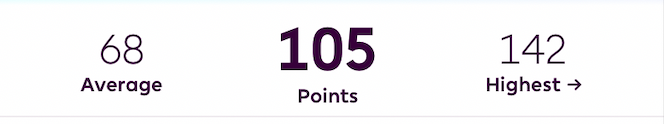

The increasing popular game: Fantasy Premier League, has captured the hearts of many football fans, with good gameweeks igniting estasy, and bad gameweeks supplying misery. Amoungst other things, a good fantasy football manager is defined by his/her ability to predict players gameweek points accurately, and putting aside their subjective feelings and emotions. This begs the questions: can we leverage the power of data science to provide an objective tool to predict player points? In this notebook I attempt this, framed as a regression problem, and use the results to create my own dream-team for each upcoming gameweek. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn import metrics 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from pulp import LpProblem, LpVariable, lpSum, LpMaximize

# Data

All data is aquired from https://github.com/vaastav/Fantasy-Premier-League which provides the statistics of every FPL player for each gameweek. Below is an example file from gameweek 5 of the 2023 season.

In [2]:
example_url = 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2023-24/gws/gw5.csv'
example_data = pd.read_csv(example_url)
example_data.head()

name position           team   xP  assists  bonus  bps  \
0       Femi Seriki      DEF  Sheffield Utd -0.5        0      0    0   
1       Radek Vítek       GK        Man Utd  0.5        0      0    0   
2  Jack Hinshelwood      MID       Brighton -0.5        0      0    0   
3      Jadon Sancho      MID        Man Utd  0.0        0      0    0   
4      Divock Origi      FWD  Nott'm Forest  2.0        0      0    3   

   clean_sheets  creativity  element  ...  team_a_score  team_h_score  threat  \
0             0         0.0      653  ...             1             2     0.0   
1             0         0.0      669  ...             3             1     0.0   
2             0         0.0      621  ...             3             1     0.0   
3             0         0.0      397  ...             3             1     0.0   
4             0         0.0      714  ...             1             1     4.0   

   total_points  transfers_balance  transfers_in  transfers_out  value  \
0             0                188           644            456     40   
1             0                230           375            145     40   
2             0                 33           171            138     45   
3             0             -10596           796          11392     68   
4             1               6189          6982            793     50   

   was_home yellow_cards  
0     False            0  
1      True            0  
2     False            0  
3      True            0  
4      True            0  

[5 rows x 40 columns]

In [3]:
example_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        717 non-null    object 
 1   position                    717 non-null    object 
 2   team                        717 non-null    object 
 3   xP                          717 non-null    float64
 4   assists                     717 non-null    int64  
 5   bonus                       717 non-null    int64  
 6   bps                         717 non-null    int64  
 7   clean_sheets                717 non-null    int64  
 8   creativity                  717 non-null    float64
 9   element                     717 non-null    int64  
 10  expected_assists            717 non-null    float64
 11  expected_goal_involvements  717 non-null    float64
 12  expected_goals              717 non-null    float64
 13  expected_goals_conceded     717 non

In [4]:
columns_not_needed_for_form = ['xP', 'element', 'fixture', 'kickoff_time', 'round', 'team_a_score', 'team_h_score', 'penalties_saved', 'penalties_missed', 'red_cards', 'yellow_cards', 'expected_goals_conceded', 'was_home', 'starts']

Raw data is manipulated into a dataframe in which each index represents a player from a specific gameweek and contains form (recent averages: xG, xA ...) and fixture (opposition recent average xGC, home/away) information. The target variable is the players true points scored that particular gameweek. The class below creates a dataframe for a particular gameweek specified as the input.

In [5]:
class PlayerData: # Base class containing functions used in training and prediction.
    def __init__(self, gw, season, form_range=4):
        self.gw = gw
        self.range = form_range
        self.season = season
        self.form_data = self.get_form_data()
        
    def get_url(self, lag): 
        return 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20' \
               + str(self.season) + '-' + str(self.season + 1) + '/gws/gw' + str(self.gw - lag) + '.csv'

    def get_form_data(self): # Extracts recent player statistics and calculated an average.
        data = pd.DataFrame()
        for i in range(self.range):
            url = self.get_url(i+1)
            temp = pd.read_csv(url).drop(columns_not_needed_for_form, axis=1)
            temp = temp.groupby(['name', 'position', 'team']).mean()
            data = pd.concat([data, temp])
        data = data.groupby(['name', 'position', 'team']).mean().reset_index(['position'])
        data = data.rename(columns={'expected_goals': 'xG',
                                   'expected_assists': 'xA',
                                   'expected_goal_involvements': 'xGI'})
        return data

    def calculate_team_defence(self): # Calculates the average xG conceded in recent weeks by each team.
        data = []
        for n in range(self.range):
            temp = pd.read_csv(self.get_url(n+1))
            temp = temp.loc[temp.minutes == 90][['team', 'expected_goals_conceded']]
            data.append(temp.groupby('team').mean()) 
        return pd.concat([data[i] for i in range(self.range)]).groupby('team').mean().expected_goals_conceded
            
    def calculate_team_attack(self): # Calculates the average xG generated in recent weeks by each team.
        data = []
        for n in range(self.range):
            temp = pd.read_csv(self.get_url(n+1))
            temp = temp[['name','team', 'expected_goals']].groupby(['name', 'team']).mean().groupby(['team']).sum()
            data.append(temp)   
        return pd.concat([data[i] for i in range(self.range)]).groupby('team').mean().expected_goals


class TrainData(PlayerData): # Inherited class to create dataframe for training a model.
    def __init__(self, gw, season, form_range=4):
        super().__init__(gw, season, form_range=4)
        self.fixture_data = self.training_fixture_data()
        self.df = self.create_final_df()

    def training_fixture_data(self): # Extracts fixture related data for each player.
        url = self.get_url(0)
        data = pd.read_csv(url)
        data = data[['name', 'team', 'was_home', 'starts','total_points', 'opponent_team']]
        data = data.rename(columns={'total_points': 'points_scored'})
        data = self.add_team_stats(data)
        return data

    def add_team_stats(self, data):
        team_defence = self.calculate_team_defence()
        team_attack = self.calculate_team_attack()
        data['opponent_xGC'] = data.opponent_team.apply(lambda x: team_defence[x-1])
        data['opponent_xG'] = data.opponent_team.apply(lambda x: team_attack[x-1])
        data['team_xGC'] = data.team.apply(lambda x: team_defence[x])
        data['team_xG'] = data.team.apply(lambda x: team_attack[x])
        data = data.drop(['opponent_team'], axis=1).groupby(['name', 'team']).mean()
        data = data[data['was_home'] % 1 == 0]
        return data

    def create_final_df(self): # Joins the fixture and form data to create final dataframe for training
        df = self.form_data.join(self.fixture_data, on=['name', 'team']) 
        df_refined = df[(df.starts == 1) & (df.minutes > 45)] 
        df_refined = df_refined.drop(['starts'], axis=1)
        return df_refined

                            
class PredData(PlayerData): # Inherited class to create predictions about upcoming fixtures.
    def __init__(self, gw, look_ahead=0, form_range=4, season=23):
        super().__init__(gw, season, form_range)
        self.look_ahead = look_ahead
        self.df = self.get_prediction_data()       
        
    def get_prediction_data(self): # Creates datafame for prediction
        fixtures = self.load_fixtures_data()
        form = self.form_data.reset_index(['team']).replace({'Nott\'m Forest': 'Forest'})
        mapping = self.map_fixtures_to_corresponding_players(form, fixtures)
        data = self.join_form_and_fixture_data(form, mapping)
        data = self.add_team_stats(data)
        data = data[data.minutes > 45]
        return data

    def load_fixtures_data(self): # Extracts fixtures from external csv file.
        fixtures = pd.read_csv('/kaggle/input/prem-fixtures/fixtures.csv', usecols=['Round Number', 'Home Team', 'Away Team'])
        fixtures = fixtures.replace({'Nottingham Forest': 'Forest'})
        return fixtures[(fixtures['Round Number'] == self.gw + self.look_ahead)]
    
    def map_fixtures_to_corresponding_players(self, form, fixtures):
        dictionary = {}
        for i, team in enumerate(form.team):
            if (fixtures['Home Team'] == team).any():
                home = 1
                oppo = fixtures[(fixtures['Home Team'] == team)]['Away Team'].item()
                dictionary[i] = []
                dictionary[i].append(home)
                dictionary[i].append(oppo)
            else:
                home = 0
                oppo = fixtures[(fixtures['Away Team'] == team)]['Home Team'].item()
                dictionary[i] = []
                dictionary[i].append(home)
                dictionary[i].append(oppo)
        return dictionary
    
    def add_team_stats(self, data):
        team_defence = self.calculate_team_defence()
        team_attack = self.calculate_team_attack()
        data['opponent_xGC'] = data.oppo.apply(lambda x: team_defence[x])
        data['opponent_xG'] = data.oppo.apply(lambda x: team_attack[x])
        data['team_xGC'] = data.team.apply(lambda x: team_defence[x])
        data['team_xG'] = data.team.apply(lambda x: team_attack[x])
        
        return data

    def join_form_and_fixture_data(self, form, mapping):
        df = pd.DataFrame(mapping).transpose().set_index(form.index)
        df.columns = ['was_home', 'oppo']
        return form.join(df, on=['name']).replace({'Forest': 'Nott\'m Forest'})

In [6]:
test = PredData(22).df

Now we contruct the dataset by concatenating multiple instances of the data extraction class. This dataset contains players of all positions. xG stats were only recoreded from GW17 of 2022/2023 season.

In [7]:
data = TrainData(gw=21, season=22, form_range=4).df
for i in range(17):
    data = pd.concat([data, TrainData(gw=22+i, season=22, form_range=4).df])
for i in range(20):
    data = pd.concat([data, TrainData(gw=5+i, season=23, form_range=4).df])

In [8]:
data.head()

position  assists  bonus     bps  \
name                team                                           
Aaron Ramsdale      Arsenal           GK      0.0   0.75  21.750   
Aaron Wan-Bissaka   Man Utd          DEF      0.0   0.75  23.000   
Adam Lallana        Brighton         MID      0.0   0.25  10.250   
Adam Smith          Bournemouth      DEF      0.0   0.00   6.000   
Aleksandar Mitrović Fulham           FWD      0.5   0.75  10.375   

                                 clean_sheets  creativity        xA       xGI  \
name                team                                                        
Aaron Ramsdale      Arsenal             0.500      0.0000  0.003710  0.003710   
Aaron Wan-Bissaka   Man Utd             0.750     16.0125  0.059899  0.064361   
Adam Lallana        Brighton            0.500      9.4500  0.040868  0.067117   
Adam Smith          Bournemouth         0.000      4.8750  0.030070  0.030070   
Aleksandar Mitrović Fulham              0.375      8.5125  0.055465  0.809802   

                                       xG  goals_conceded  ...  \
name                team                                   ...   
Aaron Ramsdale      Arsenal      0.000000            0.75  ...   
Aaron Wan-Bissaka   Man Utd      0.004463            0.25  ...   
Adam Lallana        Brighton     0.026250            1.00  ...   
Adam Smith          Bournemouth  0.000000            1.50  ...   
Aleksandar Mitrović Fulham       0.754337            0.50  ...   

                                 transfers_balance  transfers_in  \
name                team                                           
Aaron Ramsdale      Arsenal               17570.25     106218.25   
Aaron Wan-Bissaka   Man Utd               18199.25      23152.25   
Adam Lallana        Brighton                147.50       2307.50   
Adam Smith          Bournemouth            -890.75       4086.25   
Aleksandar Mitrović Fulham               373314.50     720133.25   

                                 transfers_out  value  was_home  \
name                team                                          
Aaron Ramsdale      Arsenal           88648.00  49.00       1.0   
Aaron Wan-Bissaka   Man Utd            4953.00  43.00       0.0   
Adam Lallana        Brighton           2160.00  49.00       0.0   
Adam Smith          Bournemouth        4977.00  44.00       1.0   
Aleksandar Mitrović Fulham           346818.75  70.25       1.0   

                                 points_scored  opponent_xGC  opponent_xG  \
name                team                                                    
Aaron Ramsdale      Arsenal                1.0      0.613070     2.148550   
Aaron Wan-Bissaka   Man Utd                1.0      1.208575     1.954200   
Adam Lallana        Brighton               1.0      2.225856     1.270450   
Adam Smith          Bournemouth            2.0      1.205750     1.366825   
Aleksandar Mitrović Fulham                 2.0      1.508383     1.016563   

                                 team_xGC   team_xG  
name                team                             
Aaron Ramsdale      Arsenal      1.208575  1.954200  
Aaron Wan-Bissaka   Man Utd      0.613070  2.148550  
Adam Lallana        Brighton     1.782182  1.555475  
Adam Smith          Bournemouth  1.727800  0.521250  
Aleksandar Mitrović Fulham       1.306787  1.639938  

[5 rows x 30 columns]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5971 entries, ('Aaron Ramsdale', 'Arsenal') to ('Đorđe Petrović', 'Chelsea')
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   position           5971 non-null   object 
 1   assists            5971 non-null   float64
 2   bonus              5971 non-null   float64
 3   bps                5971 non-null   float64
 4   clean_sheets       5971 non-null   float64
 5   creativity         5971 non-null   float64
 6   xA                 5971 non-null   float64
 7   xGI                5971 non-null   float64
 8   xG                 5971 non-null   float64
 9   goals_conceded     5971 non-null   float64
 10  goals_scored       5971 non-null   float64
 11  ict_index          5971 non-null   float64
 12  influence          5971 non-null   float64
 13  minutes            5971 non-null   float64
 14  opponent_team      5971 non-null   float64
 15  own_goals          

Here we can see all of the columns in the dataframe we have constructed. The points_scored columns is our target variable, which will attempt to be predicted using our other columns.

# Feature Engineering and Modelling

Since each position in FPL relies on different metrics to achieve points, I believe it will be best to fit seperate models. We can also utilise some domain knowledge to only provide features that may possibly have an effect (without being too specific because we want our model to ultimately decide)

In [10]:
data['opponent_xG_difference'] = data['opponent_xG']-data['opponent_xGC']
data['team_xG_difference'] = data['team_xG']-data['team_xGC']
data['xG_fraction'] = data['xG']/data['team_xG']
data['xA_fraction'] = data['xA']/data['team_xG']
data['transfer_activity'] = data['transfers_in'] + data['transfers_out']

There are many pairs of features that essentially describe the same thing as each other eg xG & goals, xA & assists .... In these cases, I take the expected value since over a small form period, they are less discrete which should help the models learn the dependacies. 

In [11]:
absolute_features_to_drop = ['total_points', 'assists', 'goals_scored', 'bonus', 'clean_sheets', 'goals_conceded', 'own_goals', 'transfers_out', 'transfers_in']

In [12]:
features_to_keep = [feature for feature in data.columns if feature not in absolute_features_to_drop]

In [13]:
data = data[features_to_keep]

## Useful functions and Classes

In [14]:
class ModelClass:
    def __init__(self, data, position, regressor, transformer, pca):
        self.data = data
        self.position = position
        self.pipe = None
        self.regressor = regressor
        self.transformer = transformer
        self.pca = pca
        
    def add_xG_features(self):
        pred_data = self.X_pred.copy()
        pred_data['opponent_xG_difference'] = pred_data['opponent_xG']-pred_data['opponent_xGC']
        pred_data['team_xG_difference'] = pred_data['team_xG']-pred_data['team_xGC']
        pred_data['xG_fraction'] = pred_data['xG']/pred_data['team_xG']
        pred_data['xA_fraction'] = pred_data['xA']/pred_data['team_xG']
        pred_data['transfer_activity'] = pred_data['transfers_in'] + pred_data['transfers_out']
        self.X_pred = pred_data

    def _initialize_pipeline(self):
        steps = [('preprocessor', self.transformer)]
        if self.pca is not None:
            steps.append(('pca', self.pca))
        steps.append(('regressor', self.regressor))
        pipe = Pipeline(steps=steps)
        return pipe

    def cross_val_score(self):
        X = self.data.copy()
        y = X.pop('points_scored')
        cv = KFold(n_splits=10, shuffle=True, random_state=42)
        pipe = self._initialize_pipeline()
        scores = cross_val_score(pipe, X, y, cv=cv, scoring='neg_mean_absolute_error')
        
        return -scores.mean()
        
    def fit_pipe(self):
        self.pipe = self._initialize_pipeline()
        X = self.data.copy()
        y = X.pop('points_scored')
        self.pipe.fit(X, y)

    def predict(self, gw):
        self.pred_data = PredData(gw).df
        pred_data = self.pred_data.copy()
        self.X_pred = pred_data[pred_data.position == self.position]
        teams = self.X_pred.team
        self.add_xG_features()
        features = [feature for feature in self.data.columns if feature != 'points_scored']
        self.X_pred = self.X_pred[features]
        prediction_data = self.pipe.predict(self.X_pred)
        pred = pd.DataFrame(prediction_data, index=self.X_pred.index, columns=['xP'])
        pred = pred.join(self.X_pred.value)
        pred = pred.join(teams)
        pred['Pos'] = self.position
        return pred.sort_values(by=['xP'], ascending=False)
    
    def future_predictions(self, position, gw, pred_range):
        predictions = []
        for i in range(pred_range):
            pred = PredData(gw, look_ahead=i).df
            X_pred = pred_position_dataset(position, pred)
            predictions.append(pd.DataFrame(self.pipe.predict(X_pred), index=X_pred.index, columns=['xP_'+str(i+1)])) 
        future_predictions = pd.merge(predictions[0], predictions[1], on='name')
        for i in range(pred_range-2):
            future_predictions= future_predictions.merge(predictions[i+2], on='name')
        future_predictions['mean_value'] = future_predictions.mean(axis=1)
        future_predictions = future_predictions.sort_values(by='mean_value', ascending=False)       
        return future_predictions

In [15]:
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

class MyPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components)
        self.scaler = None  

    def fit(self, X, y=None):
        if self.scaler is not None:
            self.scaler.fit(X)
        return self

    def transform(self, X, y=None):
        if self.scaler is not None:
            X = self.scaler.transform(X)
        return self.pca.transform(X)

    def fit_transform(self, X, y=None):
        if self.scaler is not None:
            X = self.scaler.fit_transform(X)
        return self.pca.fit_transform(X)

In [16]:
def plot_feature_target_relationship(data, target, features):
    num_cols = 2
    num_rows = (len(features) + 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))
    for i, feature in enumerate(features):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        sns.regplot(x=feature, y=target, data=data, ax=ax, ci=95)
        ax.set_title(f'{feature} vs {target}')
        ax.set_xlabel(feature)
        ax.set_ylabel(target)      
    for i in range(len(features), num_rows*num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])
    plt.tight_layout()
    plt.show()

def plot_home_vs_points(data, categorical_feature, points):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=categorical_feature, y=points, data=data)
    plt.title(f'{categorical_feature} vs {points}', fontsize=16)
    plt.xlabel(categorical_feature, fontsize=14)
    plt.ylabel(points, fontsize=14)
    plt.xticks(rotation=45)
    plt.show()
    
def calculate_display_correlations(df, target_variable):
    correlations = df.corr()[target_variable].sort_values(ascending=False).drop(target_variable)
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlations.to_frame(), cmap='coolwarm', annot=True, fmt=".2f", cbar=True, linewidths=.5)
    plt.title(f'Correlations with the target variable "{target_variable}"')
    plt.show()
    
    return correlations

## Goalkeepers

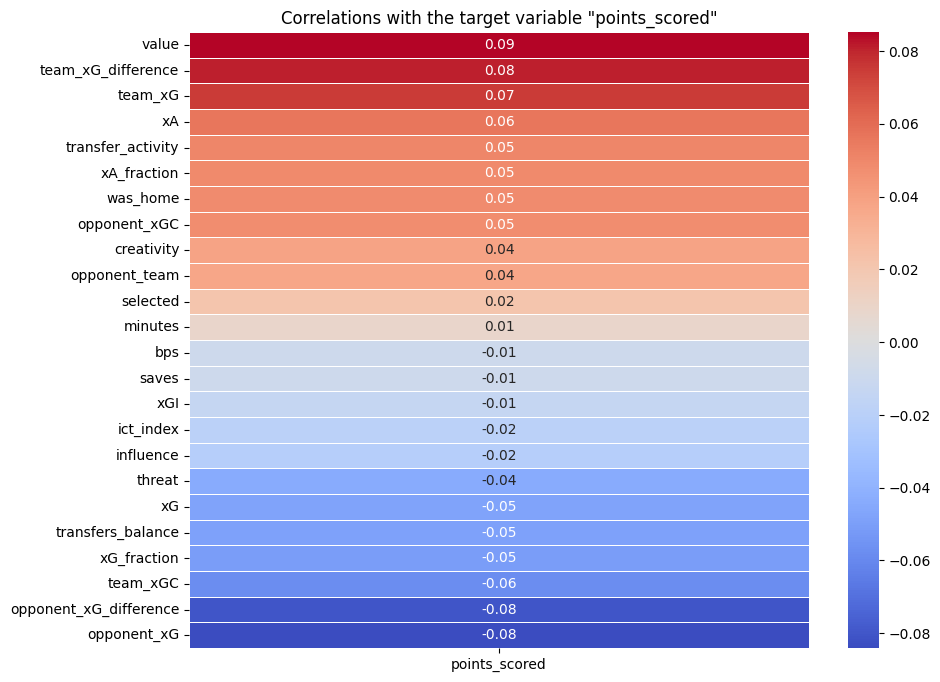

In [17]:
gk_data = data.loc[data.position == 'GK'].drop('position', axis=1)
gk_correlations = calculate_display_correlations(gk_data, 'points_scored')

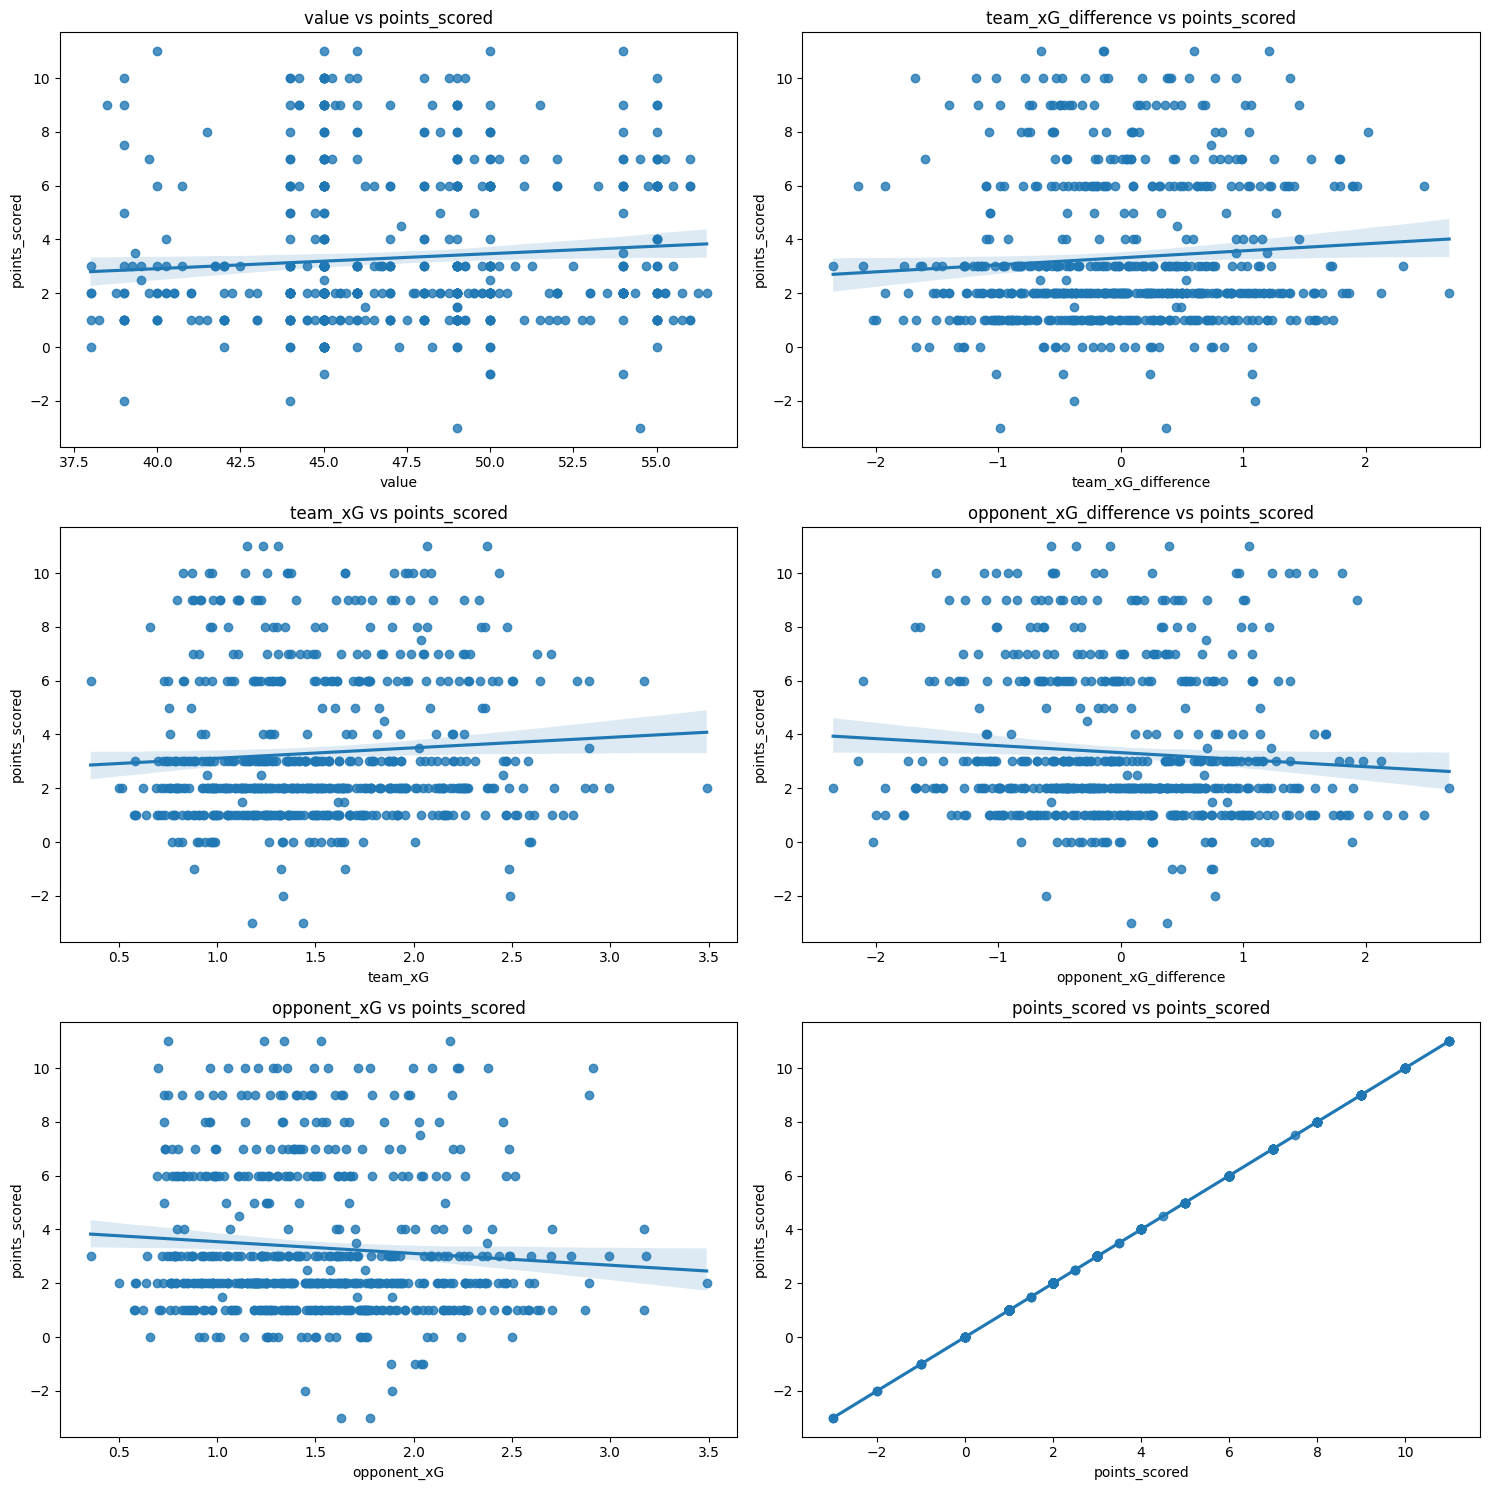

In [18]:
gk_features = [feature for feature in gk_correlations.keys() if abs(gk_correlations[feature]) > 0.06]
gk_data = gk_data[gk_features+['points_scored']]
plot_feature_target_relationship(gk_data, 'points_scored',  gk_data.columns)

In [19]:
gk_features_to_drop = ['transfer_out']#, 'assists', 'xG_fraction', 'xA_fraction', 'threat', 'xA', 'xG']
updated_gk_features = [feature for feature in gk_features if feature not in gk_features_to_drop]
gk_data = gk_data[updated_gk_features+['points_scored']]

In [20]:
models = [Ridge(), LGBMRegressor()]
transformers = [StandardScaler(), PowerTransformer(),  None]

In [21]:
gk_data.columns

Index(['value', 'team_xG_difference', 'team_xG', 'opponent_xG_difference',
       'opponent_xG', 'points_scored'],
      dtype='object')

In [22]:
best_score = 100
for model in models:
    for transformer in transformers:
        gk_model = ModelClass(gk_data,'GK', model, transformer, None)
        score = gk_model.cross_val_score()
        if score < best_score:
            best_score = score
            gk_best_model = gk_model
        print(f'Score: {score:.4f}')
gk_best_model.fit_pipe()

Score: 2.1810
Score: 2.1805
Score: 2.1809
Score: 2.4003
Score: 2.3739
Score: 2.4012


In [23]:
gk_best_model.predict(21)

xP  value            team Pos
name                                                          
Alisson Ramses Becker      3.963102  56.00       Liverpool  GK
Guglielmo Vicario          3.915979  52.75           Spurs  GK
Djordje Petrovic           3.791475  45.00         Chelsea  GK
Emiliano Martínez Romero   3.761672  51.50     Aston Villa  GK
Ederson Santana de Moraes  3.713491  55.00        Man City  GK
Thomas Kaminski            3.665982  45.00           Luton  GK
David Raya Martin          3.609330  49.00         Arsenal  GK
José Malheiro de Sá        3.266521  50.00          Wolves  GK
Wes Foderingham            3.236193  45.00   Sheffield Utd  GK
Alphonse Areola            3.210456  42.00        West Ham  GK
Mark Flekken               3.149090  45.00       Brentford  GK
André Onana                3.042273  48.00         Man Utd  GK
Matt Turner                3.031443  39.00   Nott'm Forest  GK
Dean Henderson             2.941087  44.00  Crystal Palace  GK
James Trafford             2.906813  45.00         Burnley  GK
Jordan Pickford            2.906202  44.00         Everton  GK
Martin Dubravka            2.857793  41.75       Newcastle  GK
Bernd Leno                 2.804247  47.75          Fulham  GK
Norberto Murara Neto       2.734965  46.00     Bournemouth  GK

## Defenders

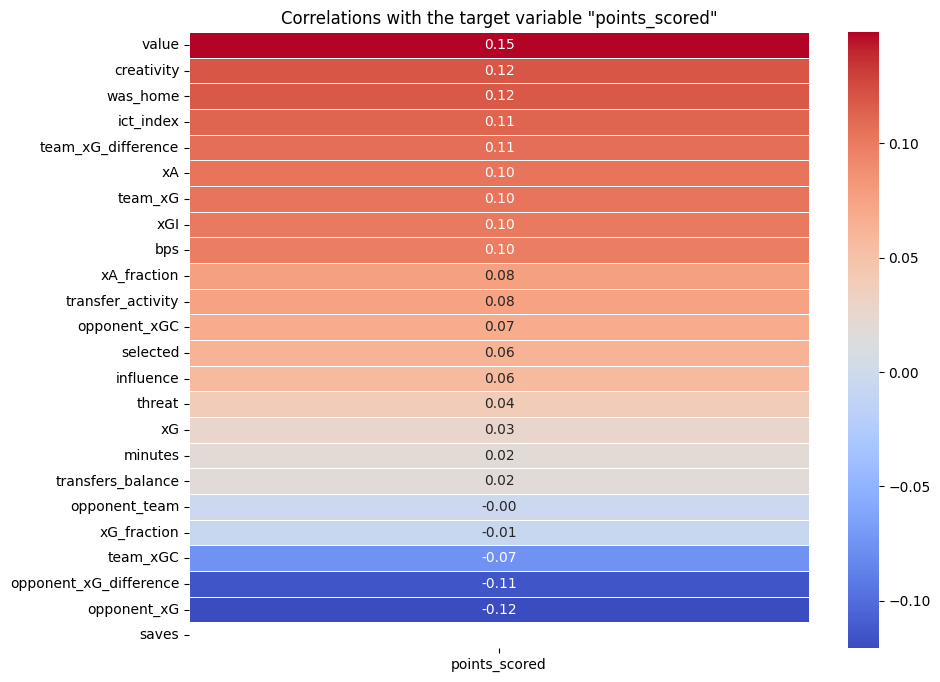

In [24]:
def_data = data.loc[data.position == 'DEF'].drop('position', axis=1)
def_correlations = calculate_display_correlations(def_data, 'points_scored')

In [25]:
def_features = [feature for feature in def_correlations.keys() if abs(def_correlations[feature]) > 0.06]
def_data = def_data[def_features+['points_scored']]
plot_feature_target_relationship(def_data, 'points_scored',  def_data.columns)

In [26]:
best_score = 100
for model in models:
    for transformer in transformers:
        def_model = ModelClass(def_data,'DEF', model, transformer, None)
        score = def_model.cross_val_score()
        if score < best_score:
            best_score = score
            def_best_model = def_model
        print(f'Score: {score:.4f}')
def_best_model.fit_pipe()

Score: 2.3422
Score: 2.3579
Score: 2.3420
Score: 1.9813
Score: 1.9853
Score: 1.9932


In [27]:
def_best_model.predict(25)

xP  value            team  Pos
name                                                              
Benjamin White                6.946809  56.00         Arsenal  DEF
Gabriel dos Santos Magalhães  6.476370  50.00         Arsenal  DEF
Oleksandr Zinchenko           5.463117  52.00         Arsenal  DEF
William Saliba                5.323620  56.00         Arsenal  DEF
Alexandre Moreno Lopera       5.175801  50.75     Aston Villa  DEF
...                                ...    ...             ...  ...
Chris Richards                0.998335  39.00  Crystal Palace  DEF
Lorenz Assignon               0.907428  40.00         Burnley  DEF
Adam Smith                    0.750154  44.00     Bournemouth  DEF
Marc Guéhi                    0.670951  44.25  Crystal Palace  DEF
Lisandro Martínez             0.644857  47.00         Man Utd  DEF

[96 rows x 4 columns]

In [28]:
def_best_model.X_pred.loc['Alexandre Moreno Lopera']

value                         50.750000
creativity                    19.850000
was_home                       0.000000
ict_index                      5.475000
team_xG_difference             0.302500
xA                             0.060000
team_xG                        1.985000
xGI                            0.117500
bps                           22.750000
xA_fraction                    0.030227
transfer_activity          62270.750000
opponent_xGC                   1.965000
selected                  181962.250000
team_xGC                       1.682500
opponent_xG_difference        -0.620000
opponent_xG                    1.345000
Name: Alexandre Moreno Lopera, dtype: float64

In [29]:
plt.hist(def_best_model.predict(25)['xP'])

(array([13.,  7., 14., 20., 21., 11.,  4.,  4.,  0.,  2.]),
 array([0.64485666, 1.27505193, 1.90524721, 2.53544248, 3.16563775,
        3.79583302, 4.42602829, 5.05622357, 5.68641884, 6.31661411,
        6.94680938]),
 <BarContainer object of 10 artists>)

## Midfielders

In [30]:
mid_data = data.loc[data.position == 'MID'].drop('position', axis=1)
mid_data = mid_data[mid_data.xGI > 0.02]
mid_correlations = calculate_display_correlations(mid_data, 'points_scored')

In [31]:
mid_features = [feature for feature in mid_correlations.keys() if abs(mid_correlations[feature]) > 0.1]
mid_data = mid_data[mid_features+['points_scored']]
plot_feature_target_relationship(mid_data, 'points_scored',  mid_data.columns)

In [32]:
mid_features_to_drop = ['tranfers_balance', 'transfers_out', 'goals_scored', 'creativity', 'threat', 'influence']
mid_features_to_keep = [feature for feature in mid_data.columns if feature not in mid_features_to_drop]
mid_data = mid_data[mid_features_to_keep]

In [33]:
best_score = 100
for model in models:
    for transformer in transformers:
        mid_model = ModelClass(mid_data,'MID', model, transformer, None)
        score = mid_model.cross_val_score()
        if score < best_score:
            best_score = score
            mid_best_model = mid_model
        print(f'Score: {score:.4f}')
mid_best_model.fit_pipe()

Score: 2.2139
Score: 2.2178
Score: 2.2150
Score: 2.3539
Score: 2.3406
Score: 2.3375


## Forwards

In [34]:
fwd_data = data.loc[data.position == 'FWD'].drop('position', axis=1)
fwd_correlations = calculate_display_correlations(fwd_data, 'points_scored')

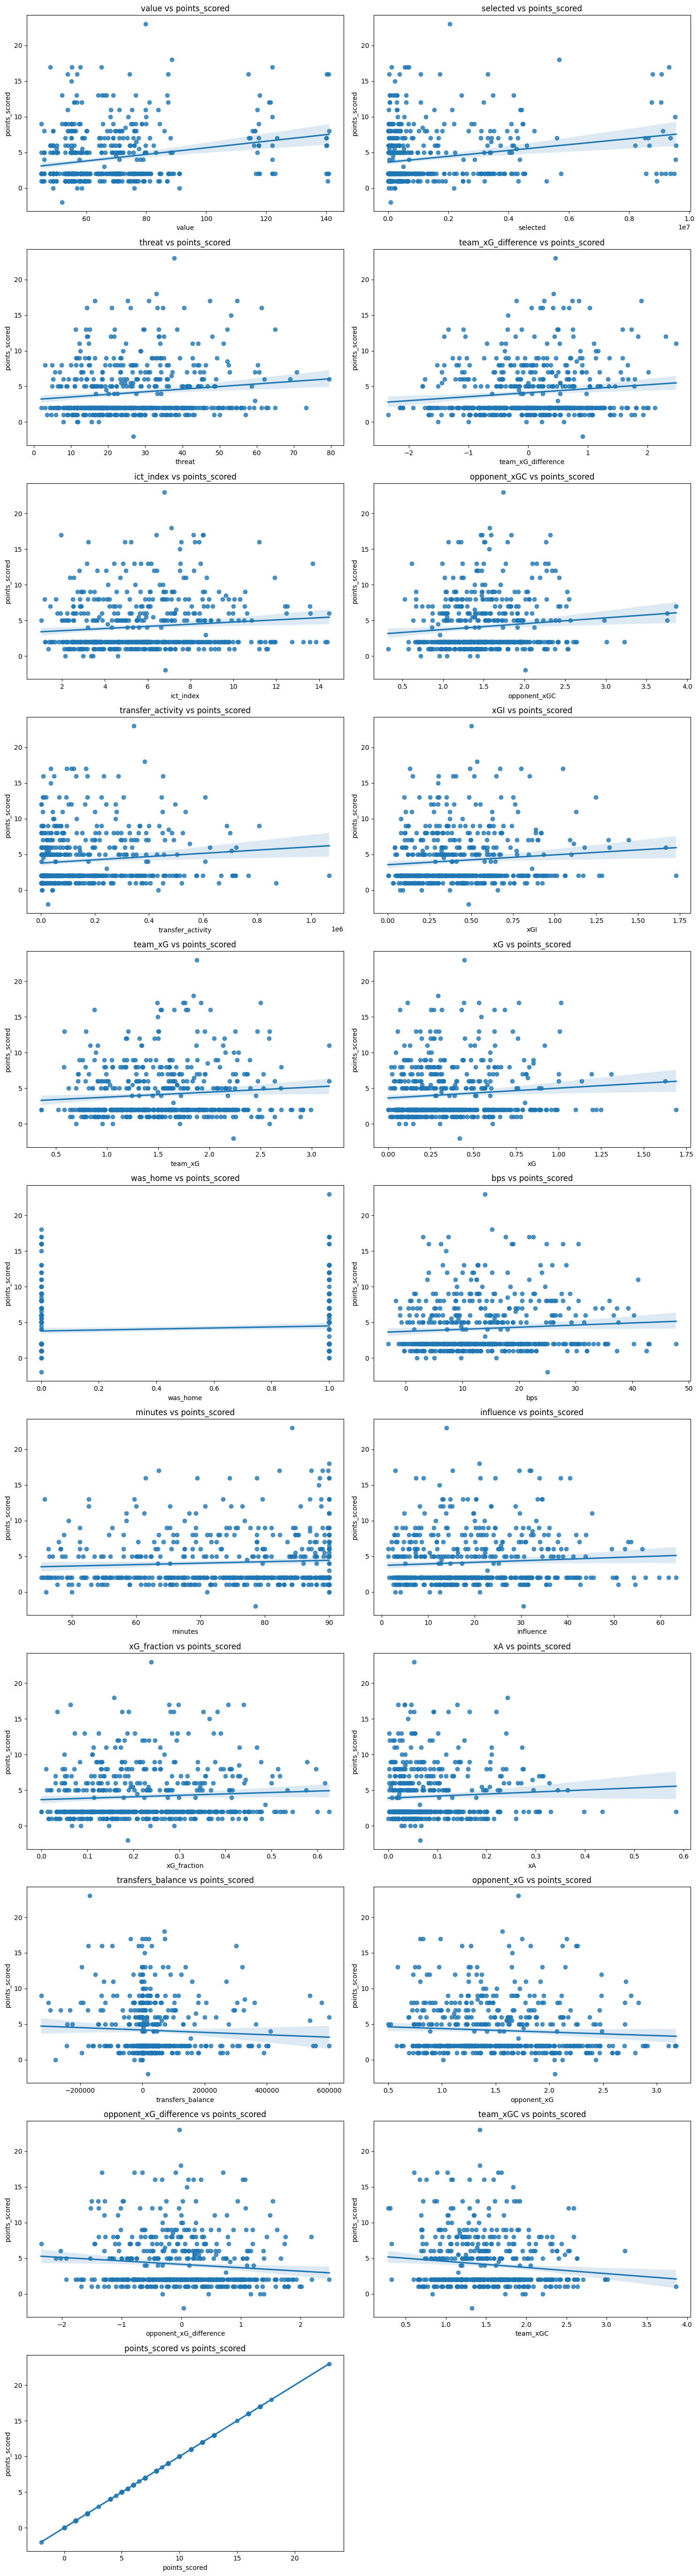

In [35]:
fwd_features = [feature for feature in fwd_correlations.keys() if abs(fwd_correlations[feature]) > 0.05]
fwd_data = fwd_data[fwd_features+['points_scored']]
plot_feature_target_relationship(fwd_data, 'points_scored',  fwd_data.columns)

In [36]:
best_score = 100
for model in models:
    for transformer in transformers:
        fwd_model = ModelClass(fwd_data,'FWD', model, transformer, None)
        score = fwd_model.cross_val_score()
        if score < best_score:
            best_score = score
            fwd_best_model = fwd_model
        print(f'Score: {score:.4f}')
fwd_best_model.fit_pipe()

Score: 2.7316
Score: 2.7339
Score: 2.7321
Score: 2.7612
Score: 2.7884
Score: 2.7558


# Dreamteam

In [37]:
def get_predictions(gameweek):
    gk_best_model.fit_pipe()
    gks = gk_best_model.predict(gameweek)
    def_best_model.fit_pipe()
    defs = def_best_model.predict(gameweek)
    mid_best_model.fit_pipe()
    mids = mid_best_model.predict(gameweek)
    fwd_best_model.fit_pipe()
    fwds = fwd_best_model.predict(gameweek)
    return pd.concat([gks, defs, mids, fwds]).reset_index()
    

In [38]:
def get_dreamteam(gw):
    
    data = get_predictions(gw)
    
    model = LpProblem(name="FPL_Team_Selection", sense=LpMaximize)
    
    selected = {i: LpVariable(cat="Binary", name=f"player_{i}") for i in range(len(data))}
    
    model += lpSum(data.loc[i, 'xP'] * selected[i] for i in range(len(data)))
    model += lpSum(data.loc[i, 'value'] * selected[i] for i in range(len(data))) <= 10000 
    model += lpSum(selected[i] for i in range(len(data))) == 11
    model += lpSum(selected[i] for i in range(len(data)) if data.loc[i, 'Pos'] == 'GK') == 1  # One goalkeeper
    model += lpSum(selected[i] for i in range(len(data)) if data.loc[i, 'Pos'] == 'DEF') >= 3  # At least 3 defenders
    model += lpSum(selected[i] for i in range(len(data)) if data.loc[i, 'Pos'] == 'MID') >= 3  # At least 3 midfielders
    model += lpSum(selected[i] for i in range(len(data)) if data.loc[i, 'Pos'] == 'FWD') >= 1  # At least 1 forward
    model += lpSum(selected[i] for i in range(len(data))) == 11
    
    team_counts = data.groupby('team').size().to_dict()
    for team, count in team_counts.items():
        model += lpSum(selected[i] for i in range(len(data)) if data.loc[i, 'team'] == team) <= 3
    
    model.solve()
    
    selected_players = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}
    for i in range(len(data)):
        if selected[i].varValue == 1:
            selected_players[data.loc[i, 'Pos']].append((data.loc[i, 'name'], data.loc[i, 'xP']))
    player_names = []
    expected_points = []

    print("Selected Team:")
    print("Goalkeeper:")
    for player in selected_players['GK']:
        print(f"{player[0]} - Expected Points: {player[1]}")
    print("\nDefenders:")
    for player in selected_players['DEF']:
        print(f"{player[0]} - Expected Points: {player[1]}")
    print("\nMidfielders:")
    for player in selected_players['MID']:
        print(f"{player[0]} - Expected Points: {player[1]}")
    print("\nForwards:")
    for player in selected_players['FWD']:
        print(f"{player[0]} - Expected Points: {player[1]}")

In [39]:
get_dreamteam(25)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/05b7b0756c8a4ebd8d4114da47c3d63d-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/05b7b0756c8a4ebd8d4114da47c3d63d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 32 COLUMNS
At line 1881 RHS
At line 1909 BOUNDS
At line 2141 ENDATA
Problem MODEL has 27 rows, 231 columns and 1155 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 67.6568 - 0.00 seconds
Cgl0004I processed model has 26 rows, 217 columns (217 integer (215 of which binary)) and 868 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -67.6568
Cbc0038I Cleaned solution of -67.6568
Cbc0038I Before mini branch and bound, 217 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did 